In [1]:
from IPython.display import display, display_html
from cobramod import __version__
from cobra import __version__ as cobra_version
from pandas import set_option
set_option('max_rows', None)
print(f'CobraMod version: {__version__}')
print(f'COBRApy version: {cobra_version}')
# From Escher:
# This option turns off the warning message if you leave or refresh this page
import escher
escher.rc['never_ask_before_quit'] = True

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
CobraMod version: 1.0.1-alpha.2
COBRApy version: 0.22.1



# Adding a synthetic homoserine cycle to a genome-scale model of *E.coli* to reproduce *in silico* experiments

## Introduction

In this tutorial we use a genome-scale model of *E.coli* (`iML1515`) [1]
and extend it with a synthetic homoserine cycle as described in this study [2].
The authors of the article describe current efforts to engineer microorganisms
toward using methanol as a carbon source. Methanol can be oxidized into
formaldehyde, which can be later utilized for the production of C3-compounds
.
In this paper, the authors designed a synthetic cycle (homoserine cycle) that
can outperform the natural serine cycle with respect to biomass yield.
In this test case, we recreate the *in silico* experiments using
CobraMod and visualize fluxes of the homoserine pathway.

## Loading CobraMod, the *E.coli* model and setting the growth medium

We use the BiGG Models repository to retrieve the `iML1515` model and load it 
using COBRApy. The model includes 2712 reactions, 1877 metabolites, and 1516 
genes. Using basic shell commands we download the model into or current working 
directory.


In [2]:
!wget http://bigg.ucsd.edu/static/models/iML1515.json  -nc -q

We load the *E.coli* model using the COBRApy function
`load_json_model`.
From CobraMod we load the function
[cobramod.add_pathway()](
module/cobramod/index.html#cobramod.add_pathway
) and the Python module [pathlib](
https://docs.python.org/3/library/pathlib.html
) to define the system's path where CobraMod stores the metabolic pathway
information (`dir_data`). All pathway information will be saved here.


In [3]:
from pathlib import Path

from cobramod import add_pathway
from cobra.io import load_json_model, write_sbml_model, read_sbml_model

# Defining system path for data
dir_data = Path.cwd().joinpath("data")

# Loading model of iML1515
model = load_json_model("iML1515.json")
model

Name,iML1515
Memory address,0x07f8a39deb7d0
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, periplasm, extracellular space"


To demonstrate CobraMod's functionalities, we first repeat the model curation as listed in the [original publication](https://www.sciencedirect.com/science/article/pii/S1096717620300513#sec4.2).

In [4]:
model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.MMM.bounds = (-1000, 1000)

for reaction in ["POR5", "GLYCK", "FDH4pp", "FDH5pp", "ATPM", "PFL", "OBTFL"]:
    model.reactions.get_by_id(reaction).knock_out()

for rxn in model.boundary:
    # knock out all other carbon-related transporters
    if "C" in rxn.check_mass_balance():
        rxn.bounds = (0.0, 1000)

model.reactions.get_by_id("EX_meoh_e").bounds = (-10.0, 1000)
model.reactions.get_by_id("EX_co2_e").bounds = (-1000, 1000)


## Adding the homoserine cycle

In the next step, the authors used a function which loads a .csv file and creates the reactions to be added to the model based on the information given in the file. The cell below shows the content of this file.

In [5]:
!wget https://github.com/he-hai/PubSuppl/raw/master/2020_Promiscuous%20aldolases/2_FBA/NewRxns4Full_HomSer.csv  -nc -q | cat NewRxns4Full_HomSer.csv

RxnID, RxnName, RxnFormula, Subsystem, LowerBound, UpperBound
MeDH, methanol dehydrogenase (NAD), meoh_c + nad_c <=> fald_c + nadh_c + h_c, MeDH, -1000, 1000
SAL, serine aldolase, gly_c + fald_c --> ser__L_c, HomSerCyc, 0, 1000
HAL, HOB aldolase, pyr_c + fald_c --> hob_c, HomSerCyc, 0, 1000
HAT, HOB amino-transferase, hob_c + glu__L_c <=> hom__L_c + akg_c, HomSerCyc, 0, 1000
FDH, NAD-dependent formate dehydrogenase, for_c + nad_c --> co2_c + nadh_c, SerCyc, 0, 1000

The synthetic cycle consist of seven reactions of which three are not
yet in the model. Additionally, there are three other reactions which
are required for the pathway to be functional:
- *ACDH* (Acetaldehyde dehydrogenase)
- *MeDH* (Methanol dehydrogenase, converts methanol to formaldehyde)
- *FDH* (formate dehydrogenase, converts formate and NAD+ to CO2 and NADH.)

Of these reactions, *MeDH* and *FDH*  are not yet in the model. Here, we use 
CobraMod to add these new reactions and to define the set of new and already
existing reactions that together form the pathway. 

**Homoserine cycle**

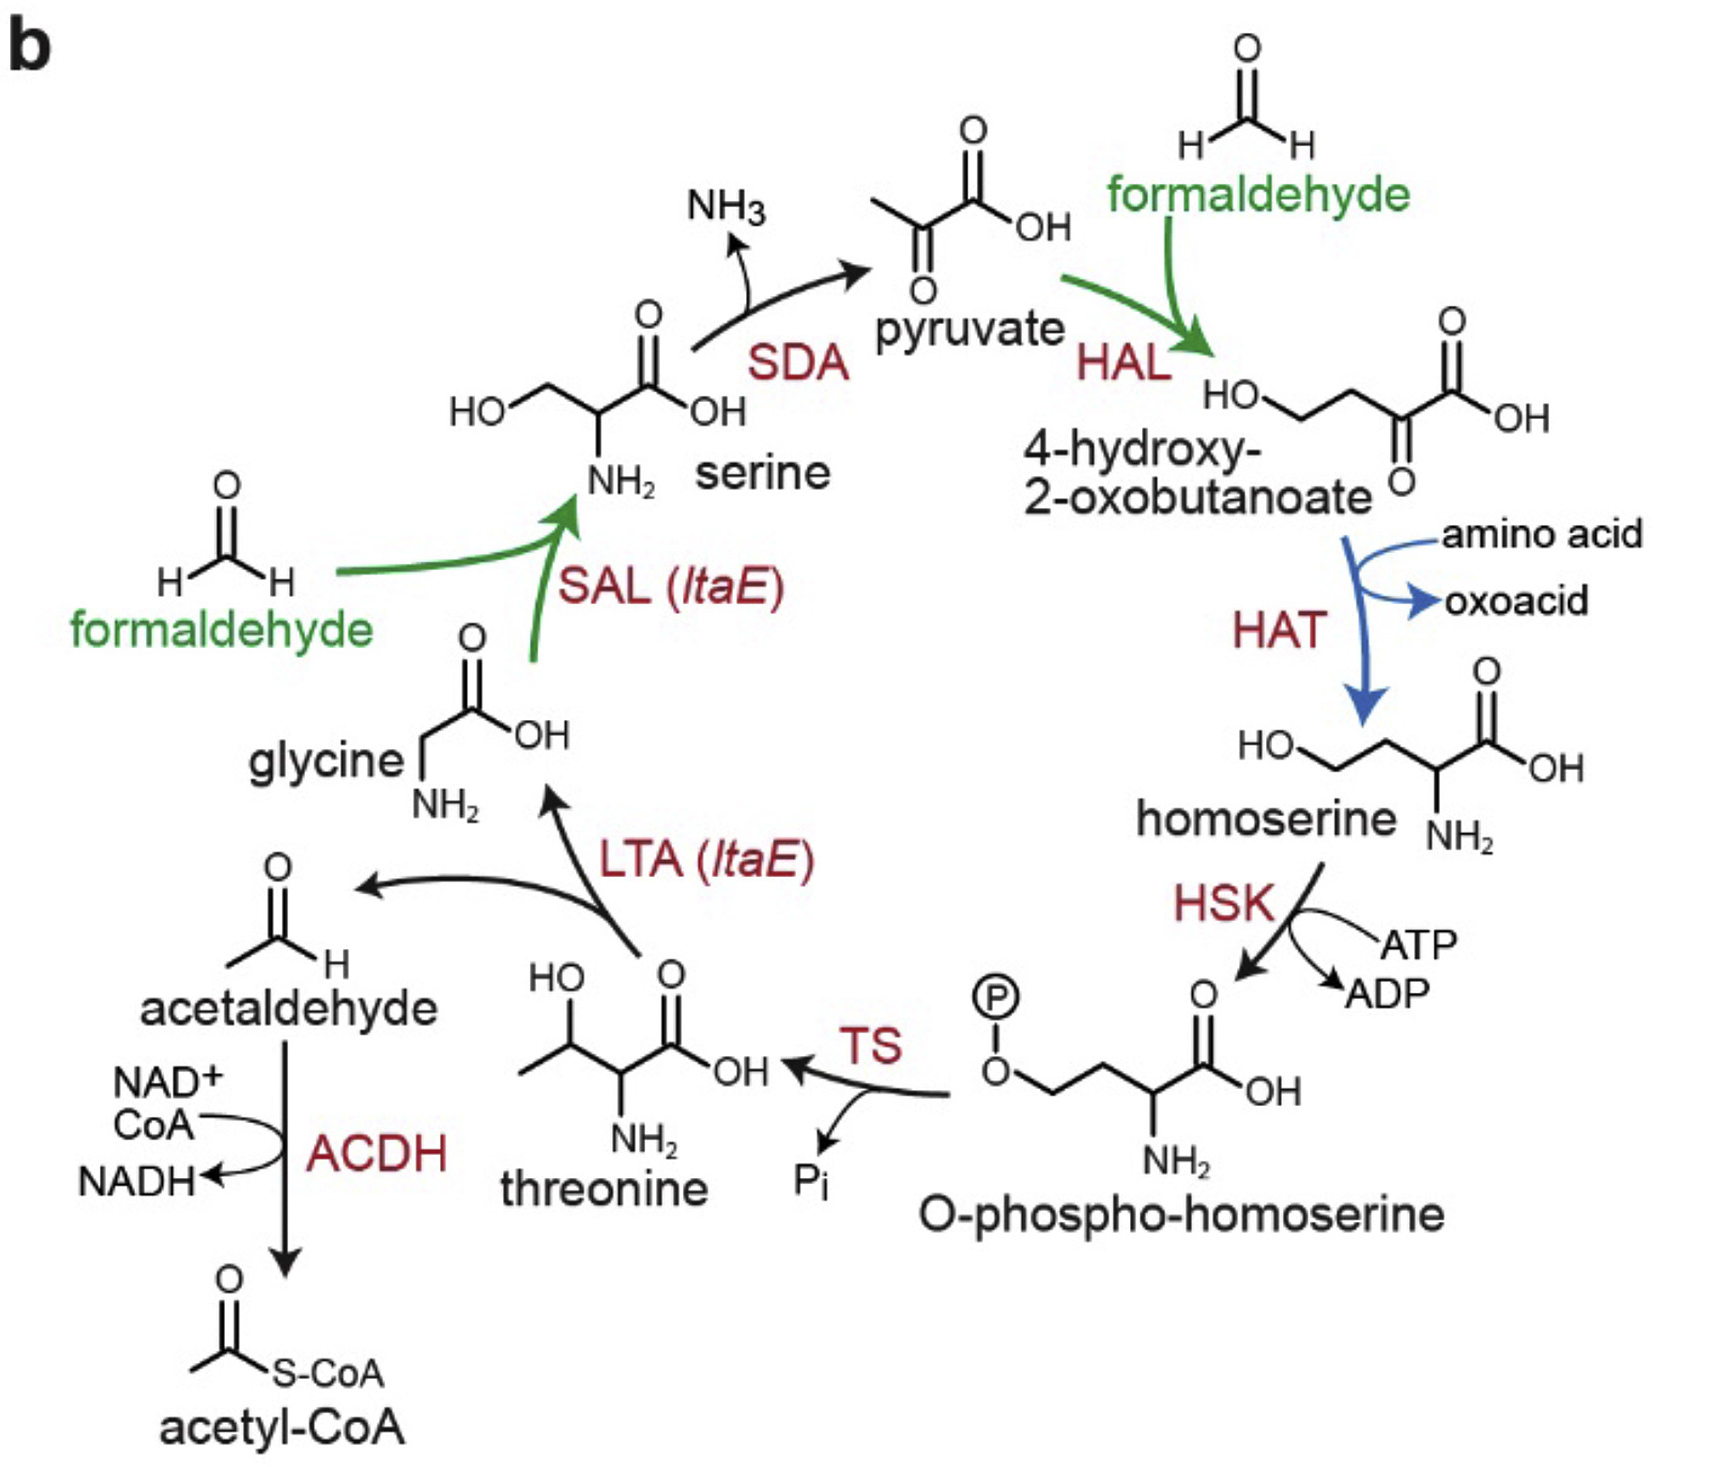

Next, we define the list of reactions that we want to include. In order to make use of CobraMod's full functionalities, we need to consider their position in the pathway. CobraMod runs a non-zero flux test for each newly added reaction (see
'Non-zero flux test' and 'Curation process') and for the test to be sucessful we need to make sure that precursor metabolites for each newly added reaction can already be synthezised in the model.

There are two types of strings here:
  - Strings with the new reaction information. This type of reaction is refered to as user-curated reaction (in contrast to reaction information downloaded from a database). The syntax follows:
    > Reaction identifier, name | equation

  - Strings with the identifiers of those reactions that are part of the pathway and already in the model.

CobraMod tries to find the respecitive reaction's metabolites in the model. If they are not present in the model, CobraMod creates and adds these metabolites.


In [6]:
reactions = [
    "MeDH, methanol dehydrogenase (NAD) | meoh_c + nad_c <=> fald_c + nadh_c + h_c",
    "SAL, serie aldolase | gly_c + fald_c --> ser__L_c",
    "SERD_L", # already in model
    "HAL, HOB aldolase | pyr_c + fald_c --> hob_c",
    "HAT, HOB amino-transferase  | hob_c + glu__L_c <=> hom__L_c + akg_c",
    "HSK", # already in model
    "THRS", # already in model (TS)
    "THRA", # already in model (LTA)

    # Reactions below will be also included
    "ACALD", # already in model (ACDH)
    "FDH, NAD-dependent formate dehydrogenase | for_c + nad_c --> co2_c + nadh_c"
]

We then use the [add_pathway()](
module/cobramod/index.html#cobramod.add_pathway
) function to add this list of reactions as a pathway to our model. The first argument `model` specifies the model to be extended. The argument `group` assignes our [cobramod.Pathway](
module/cobramod/index.html#cobramod.Pathway
) a name, in this case *Homoserine-PWY*. When specifying the argument `filename` CobraMod creates a summary of the changes that were made to the model. Here, we save the summary as *summary.txt* and use it to check that the new reactions were added to the model.

In [7]:
add_pathway(
    model=model,
    pathway=reactions,
    compartment="c",
    directory=dir_data,
    group="Homoserine-PWY",
    filename="summary.txt",
)

/home/stefano/Documents/IPK/cobramod/src/cobramod/core/creation.py:792: UserWarning: Manually-curated metabolite "hob_c" does not have a chemical formula and charge. Please modify the values manually. Charge set to 0, and formula to "X".
  warn(message=msg, category=UserWarning)
/home/stefano/Documents/IPK/cobramod/src/cobramod/utils.py:52: UserWarning: Reaction "HAL" unbalanced. Following atoms are affected. Please verify:
{'charge': 1.0, 'C': -4.0, 'H': -5.0, 'O': -4.0, 'X': 1.0}
  warn(message=msg, category=UserWarning)
/home/stefano/Documents/IPK/cobramod/src/cobramod/utils.py:52: UserWarning: Reaction "HAT" unbalanced. Following atoms are affected. Please verify:
{'charge': -1.0, 'X': -1.0, 'C': 4.0, 'H': 5.0, 'O': 4.0}
  warn(message=msg, category=UserWarning)


Number of       new   | removed entities in
*=====================|===================*
Reactions        5    |    0              
Metabolites      1    |    0              
Exchange         0    |    0              
Demand           0    |    0              
Sinks            1    |    0              
Genes            0    |    0              
Groups           1    |    0              



After running the cell, we get 3 warnings. CobraMod informs the
user about inconsistencies and missing information in the model. Because we
manually added reactions that were created from an equation (curated reaction), CobraMod recognizes these reactions and tries to identify if the respective metabolites are already in the model. In our case only one metabolite `hob_c` was not found in the model. If a metabolite was not found in the model CobraMod creates it without a chemical formula and charge and raises a warning suggesting the user to manually curate this metabolite. 

The other two warnings refer to two reactions (*HAL* and *HAT*) which involve
`hob_c`. Since this metabolite does not have a chemical formula, the reactions are recognized as unbalanced.

At the end, we see a short summary of the changes made to the model.
We also have the option to read the full summary. This summary is created by
CobraMod using the argument `filename`. This full summary includes all reactions, metabolites, genes, and groups of the model after using the add_pathway function. Here, we show the last 30 lines of the file.


In [8]:
!tail summary.txt -n 32

New:
Reactions:
['MeDH', 'SAL', 'HAL', 'HAT', 'FDH']
Metabolites:
['hob_c']
Exchange:
[]
Demand:
[]
Sinks:
['SK_hob_c']
Genes:
[]
Groups:
['Homoserine-PWY']

Removed:
Reactions:
[]
Metabolites:
[]
Exchange:
[]
Demand:
[]
Sinks:
[]
Genes:
[]
Groups:
[]



We can use COBRApy to inspect the pathways, i.e. groups in the model. Using the method `Model.groups.get_by_id()` we can search for the new pathway using its identifier `'Homoserine-PWY`.
In the cell below the reactions and genes of the pathway are listed. Moreover, we can see attributes for the pathway visualization.

The method
[Pathway.visualize()](
module/cobramod/core/pathway/index.html#cobramod.core.pathway.Pathway.visualize
) generates pathway maps which can be
easily customized with user-defined colors, flux ranges, and gradient settings using [Escher](
https://escher.readthedocs.io/en/latest/
). For instance, we can change the color of the reaction arrows to green for positive flux values and to red for negative flux values by setting the respective attributes of the pathway and we can pass on a COBRApy flux solution with the argument `solution_fluxes`.

In [9]:
model.groups.get_by_id("Homoserine-PWY")

Pathway identifier,Homoserine-PWY
Name,
Memory address,0x0140231640046928
Reactions involved,"MeDH, SAL, SERD_L, HAL, HAT, HSK, THRS, THRA, ACALD, FDH"
Genes involved,"b3117, b2797, b4471, b3708, b1814, b0003, b0004, b2551, b0870, b0351, b1241"
Visualization attributes,vertical = False color_negative = None color_positive = None color_quantile = False


In [10]:
solution01 = model.optimize()
print(solution01)
model.groups.get_by_id("Homoserine-PWY").color_negative = "red"
model.groups.get_by_id("Homoserine-PWY").color_positive = "green"
model.groups.get_by_id("Homoserine-PWY").visualize(solution_fluxes=solution01)

<Solution 12.330 at 0x7f8a391e7290>


Builder(never_ask_before_quit=True, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0…

## Saving and reloading the model

After modifying the *E.coli* model we can save it in our current working directory
using the native COBRApy function `write_sbml_model`.

In [11]:
%%capture
write_sbml_model(cobra_model=model, filename="iML1515_homoserine.sbml")

For demonstration purposes we delete the previous model
from our environment and load the *E.coli* model with the new homoserine
cycle. To do so, we use the native COBRApy function `read_sbml_mdodel` with the path of your new model.

In [12]:
del model
model = read_sbml_model("iML1515_homoserine.sbml")
model

Name,iML1515
Memory address,0x07f8a391f6d50
Number of metabolites,1878
Number of reactions,2718
Number of groups,1
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, periplasm, extracellular space"


The model was correctly loaded and behaves like a regular COBRApy object.
However, CobraMod uses a child-class of `cobrapy.Group` and it loses its 
functionalities when loaded with COBRApy. To overcome this, we need to
transform the groups back into pathway objects to be able to use Escher. To do so, we run the CobraMod function `model_convert` which restores all pathway functionalities. (See "Converting COBRApy groups back to CobraMod pathways" in the documentation).

In [13]:
from cobramod import model_convert

# Before
model.groups.get_by_id("Homoserine-PWY")

model_convert(model)

# After transformation
display(model.groups.get_by_id("Homoserine-PWY"))

model.groups.get_by_id("Homoserine-PWY").visualize()

Pathway identifier,Homoserine-PWY
Name,
Memory address,0x0140231164231888
Reactions involved,"MeDH, SAL, SERD_L, HAL, HAT, HSK, THRS, THRA, ACALD, FDH"
Genes involved,"b2797, b3708, b1814, b3117, b4471, b0003, b0004, b0870, b2551, b0351, b1241"
Visualization attributes,vertical = False color_negative = None color_positive = None color_quantile = False


Builder(never_ask_before_quit=True, reaction_scale={}, reaction_styles=['color', 'text'])

## Reading the debug file

When creating and extending metabolic models, it is important to document the curation process to facilitate easy understanding and reproducibility of the model. To this end, CobraMod writes in a log file documenting all curration steps that were performed. The cell below shows the last 20 lines of this log file (*debug.log*). We can see that a non-zero-flux test was performed for every newly added reaction. These reactions were then added to the Pathway object, and this object was then added to the model. At the end, we can see the transformation of the COBRApy group to a Pathway-object.

In [14]:
!tail debug.log -n 20

2021-12-08 09:45:20,344 INFO Non-zero flux test for reaction HAT passed.
2021-12-08 09:45:20,346 INFO Reaction "HAT" added to group "Homoserine-PWY".
2021-12-08 09:45:20,346 INFO Test to carry non-zero flux for "HSK" started.
2021-12-08 09:45:20,356 INFO Non-zero flux test for reaction HSK passed.
2021-12-08 09:45:20,358 INFO Reaction "HSK" added to group "Homoserine-PWY".
2021-12-08 09:45:20,358 INFO Test to carry non-zero flux for "THRS" started.
2021-12-08 09:45:20,359 INFO Non-zero flux test for reaction THRS passed.
2021-12-08 09:45:20,361 INFO Reaction "THRS" added to group "Homoserine-PWY".
2021-12-08 09:45:20,361 INFO Test to carry non-zero flux for "THRA" started.
2021-12-08 09:45:20,382 INFO Non-zero flux test for reaction THRA passed.
2021-12-08 09:45:20,385 INFO Reaction "THRA" added to group "Homoserine-PWY".
2021-12-08 09:45:20,385 INFO Test to carry non-zero flux for "ACALD" started.
2021-12-08 09:45:20,395 INFO Non-zero flux test for reaction ACALD passed.
2021-12-08 09

## References

1. Monk, J. M., Lloyd, C. J., Brunk, E., Mih, N., Sastry, A., King, Z., … Palsson, B. O. (2017). IML1515, a knowledgebase that computes Escherichia coli traits. Nature Biotechnology, 35(10), 904–908. doi: 10.1038/nbt.3956
2. He, H., Höper, R., Dodenhöft, M., Marlière, P., & Bar-Even, A. (2020). An optimized methanol assimilation pathway relying on promiscuous formaldehyde-condensing aldolases in E. coli. Metabolic Engineering, 60, 1–13. doi: 10.1016/j.ymben.2020.03.002
3. Beber, M., & Lieven, C. (2020). memote—The genome-scale metabolic model test suite (Version 0.11.1). Novo Nordisk Foundation Center for Biosustainability, Technical University of Denmark.